In [20]:
import phenograph
import pandas as pd
import numpy as np
import community
import networkx as nx
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import Normalize
from matplotlib.patches import Patch
from random import shuffle
import pickle

In [2]:
#TSNE embeddings from file
raw_embedded = pd.read_csv("./TSNE.csv", header=-1)
raw_embedded.columns = ['x', 'y']
x = raw_embedded['x'].values
y = raw_embedded['y'].values

In [3]:
#Louvain & phenograph communities from pickle
infile = open('phenocommunities.pickle','rb')
pheno = pickle.load(infile)
infile.close()
infile = open('louvaincommunities.pickle','rb')
louvain = pickle.load(infile)
infile.close()

In [4]:
#Convert communities dictionary to dataframe
louvaindf = pd.DataFrame(list(louvain.items()))
louvaindf.columns = ['node', 'community']

In [5]:
#Convert flat communities list to dataframe
phenodict = {}
for c, key in enumerate(pheno):
    phenodict[c] = key
phenodf = pd.DataFrame(list(phenodict.items()))
phenodf.columns = ['node', 'community']

In [6]:
#Make empty jaccard matrix
jaccardmatrix = np.zeros((len(set(louvaindf['community'])), len(set(louvaindf['community']))))


In [7]:
#Calculate jaccard similarity for each cluster combination
for x in range(len(set(louvaindf['community']))):
    for y in range(len(set(louvaindf['community']))):
        louvains = set(louvaindf[louvaindf['community'] == x]['node'])
        phenos = set(phenodf[phenodf['community'] == y]['node'])
        sim = len(louvains & phenos) / len (louvains | phenos)
        jaccardmatrix[x][y] = sim

/home/paul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


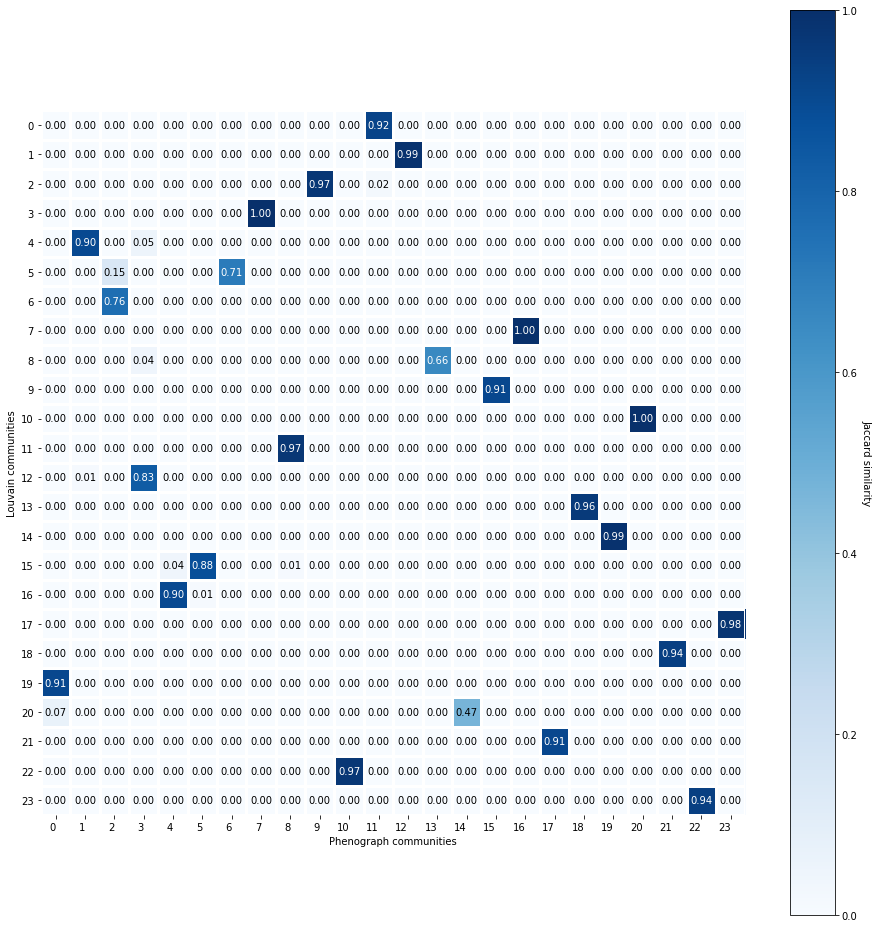

In [52]:
plt.rcParams['figure.figsize'] = [13, 13]
# https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-0, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

fig, ax = plt.subplots()
im, cbar = heatmap(np.round(jaccardmatrix, 2),
                   row_labels=louvaindf['community'].unique() ,
                   col_labels=set(phenodf['community']),
                   cmap=plt.cm.Blues,
                   cbarlabel="Jaccard similarity")
plt.xlabel("Phenograph communities")
plt.ylabel("Louvain communities")
texts = annotate_heatmap(im)
fig.tight_layout()
plt.show()


In [64]:
#Create mappings from pheno cluster to louvain cluster
#will fail if max value is present in a row twice
phenotolouvain = {}
for y in range(len(np.round(jaccardmatrix, 2))):
    item = max(np.round(jaccardmatrix, 2)[y])
    itemindex = list((np.round(jaccardmatrix, 2)[y])).index(item)
    phenotolouvain[itemindex] = y


0.92
0.99
0.97
1.0
0.9
0.71
0.76
1.0
0.66
0.91
1.0
0.97
0.83
0.96
0.99
0.88
0.9
0.98
0.94
0.91
0.47
0.91
0.97
0.94


In [66]:
#mappings from pheno cluster to louvain cluster
phenotolouvain

{0: 19,
 1: 4,
 2: 6,
 3: 12,
 4: 16,
 5: 15,
 6: 5,
 7: 3,
 8: 11,
 9: 2,
 10: 22,
 11: 0,
 12: 1,
 13: 8,
 14: 20,
 15: 9,
 16: 7,
 17: 21,
 18: 13,
 19: 14,
 20: 10,
 21: 18,
 22: 23,
 23: 17}

In [67]:
#tsne from file
raw_embedded = pd.read_csv("./TSNE.csv", header=-1)
raw_embedded.columns = ['x', 'y']
x = raw_embedded['x'].values
y = raw_embedded['y'].values

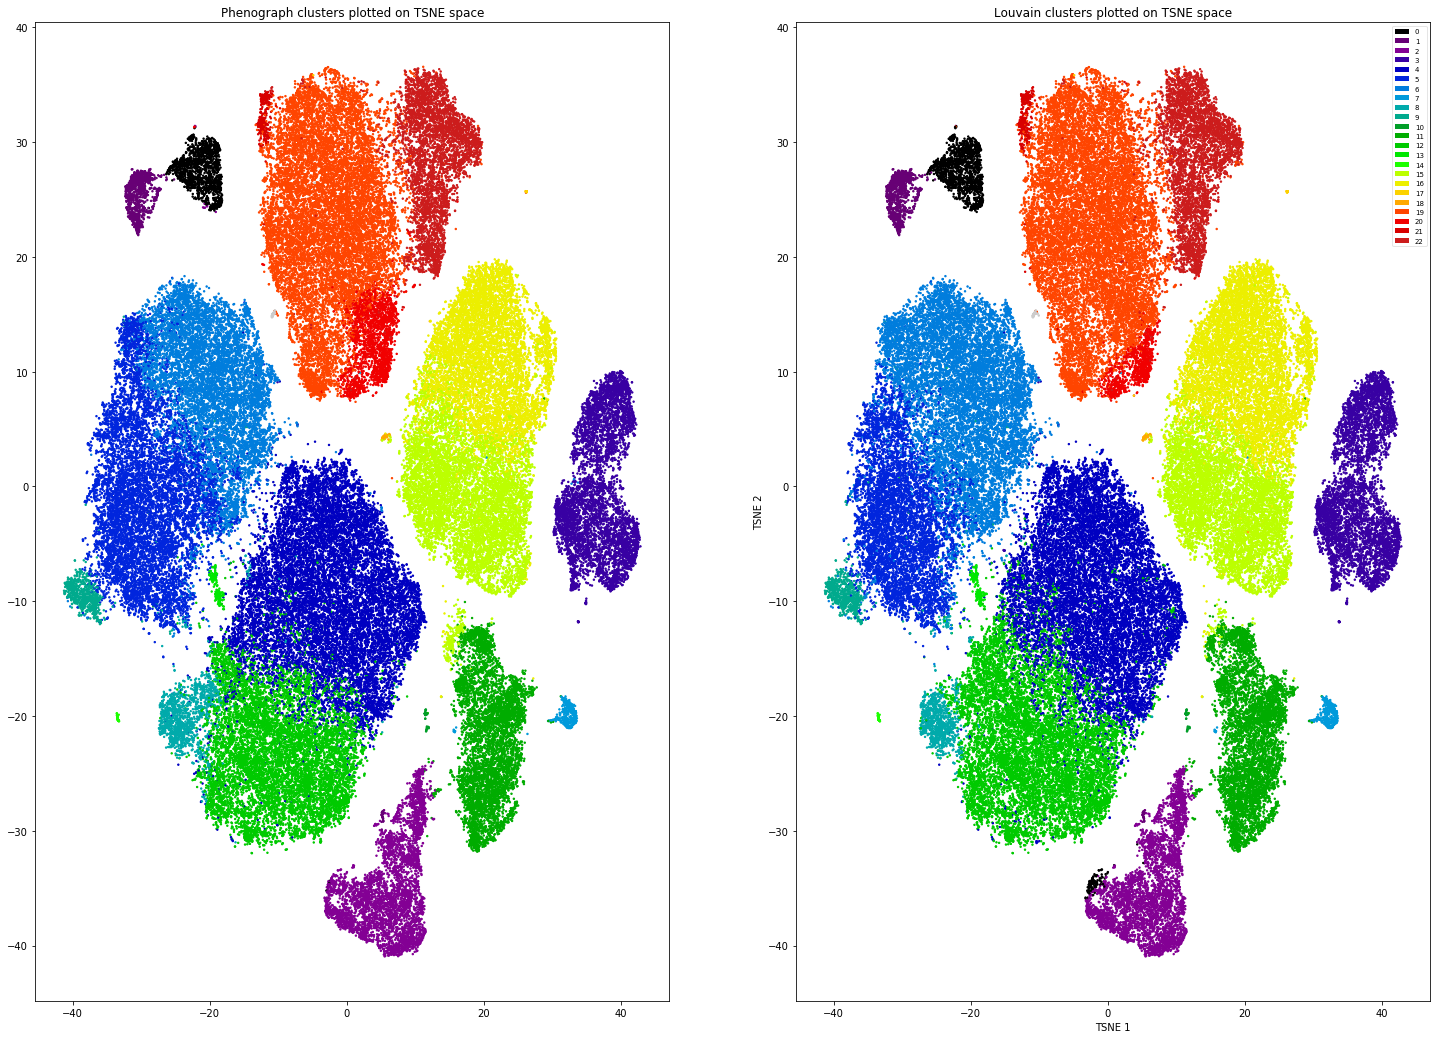

In [102]:
#set figure size
plt.rcParams['figure.figsize'] = [25, 18]
#layout 2 figures
fig, ax = plt.subplots(1, 2)
#plot louvain
labelset = list(set(louvaindf['community']))
colors = []
norm = Normalize(vmin=0, vmax=len(labelset)-1)
cmap = plt.cm.get_cmap('nipy_spectral')
for i in range(len(labelset)):
    colors.append(cmap(norm(i)))
ax[0].scatter(x,y, s=2, c=[colors[i] for i in louvaindf['community']])
ax[0].set_title("Phenograph clusters plotted on TSNE space")
#plot pheno mapped as louvain cluster numbers
ax[1].scatter(x,y, s=2, c=[colors[i] for i in [phenotolouvain[key] for key in phenodf['community']]])
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
handles = []
for i in range(len(labelset)-1):
    handles.append(Patch(facecolor=colors[i]))
plt.legend(handles, labelset, loc='upper right', prop={'size': 7}, framealpha=0.5)
ax[1].set_title("Louvain clusters plotted on TSNE space")
plt.show()

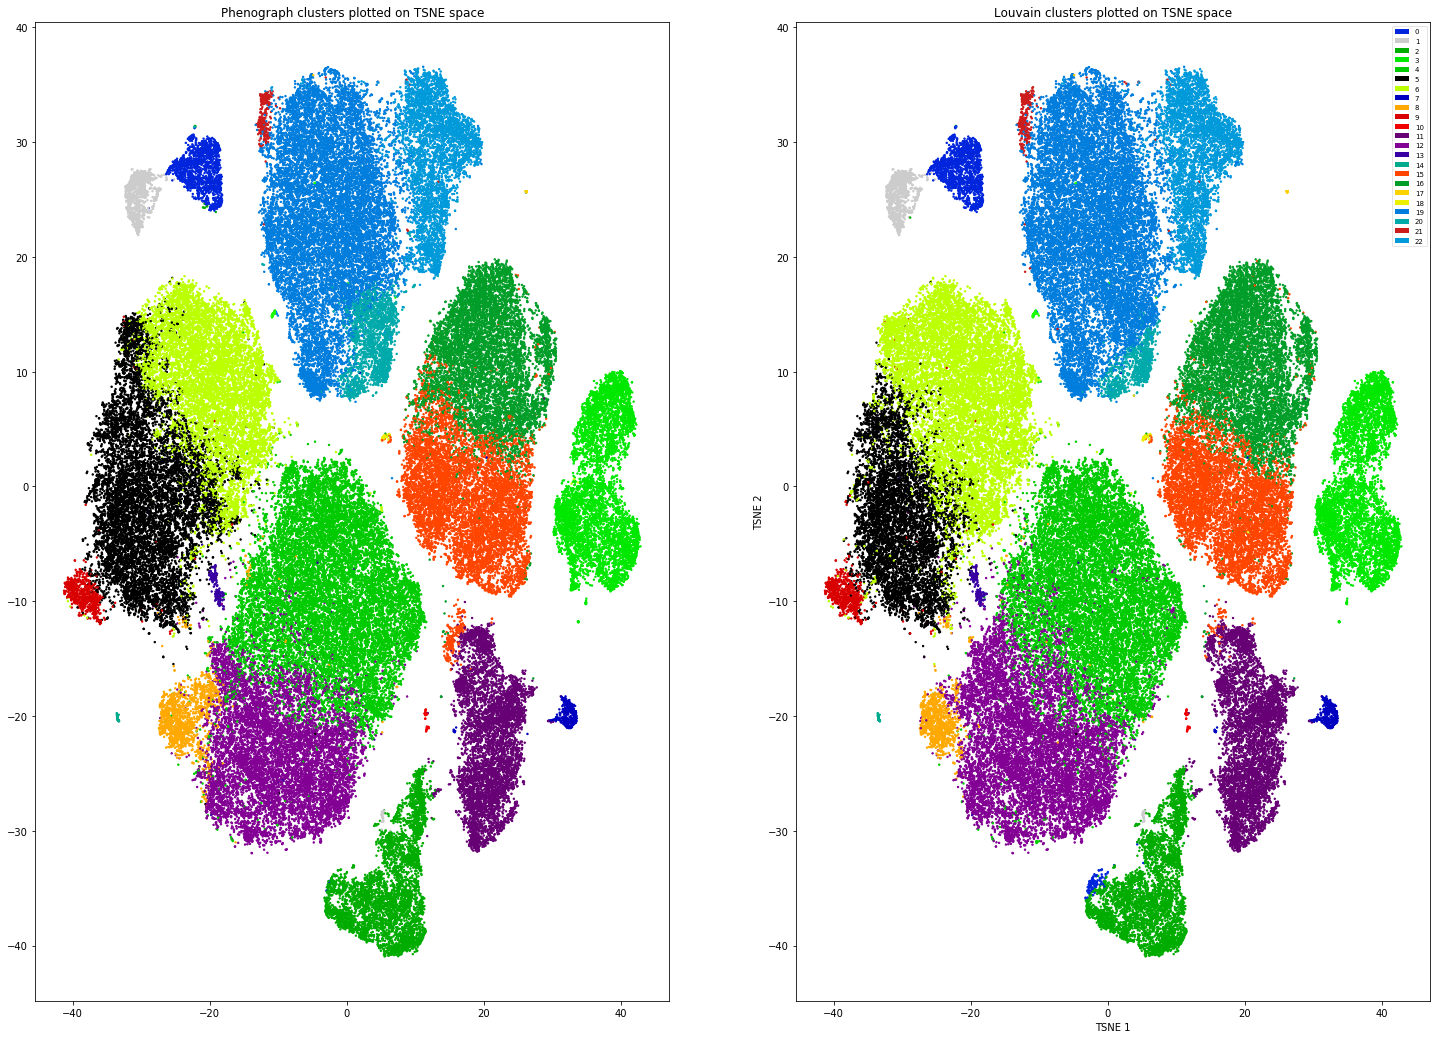

In [104]:
#SAME PLOT BUT COLORS ARE SHUFFLED
plt.rcParams['figure.figsize'] = [25, 18]
#layout 2 figures
fig, ax = plt.subplots(1, 2)
#plot louvain
labelset = list(set(louvaindf['community']))
colors = []
norm = Normalize(vmin=0, vmax=len(labelset)-1)
cmap = plt.cm.get_cmap('nipy_spectral')
for i in range(len(labelset)):
    colors.append(cmap(norm(i)))
random.shuffle(colors)

ax[0].scatter(x,y, s=2, c=[colors[i] for i in louvaindf['community']])
ax[0].set_title("Phenograph clusters plotted on TSNE space")
#plot pheno mapped as louvain cluster numbers
import random
ax[1].scatter(x,y, s=2, c=[colors[i] for i in [phenotolouvain[key] for key in phenodf['community']]])
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
handles = []
for i in range(len(labelset)-1):
    handles.append(Patch(facecolor=colors[i]))
plt.legend(handles, labelset, loc='upper right', prop={'size': 7}, framealpha=0.5)
ax[1].set_title("Louvain clusters plotted on TSNE space")
plt.show()